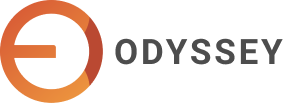
# Odyssey Python Client Documentation

Welcome to the documentation for the Python Client connection to the Odyssey Analytics Elasticsearch Data Base!
The purpose of this document is to get you acquainted with common querying techniques to access your data,
establish best practices, and point you in the direction of further resources.

## Setup

### Dependencies
As all great python programs start, we need to import the libraries we will depend upon. While only
ElasticSearch is required to access the data, we will use additional data science packages in this tutorial.

In [ ]:
# install package for elastic search
!pip install elasticsearch

# # Import libraries
import elasticsearch
import pandas as pd
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, client

### Credentials
To access the REST API, you will need to request an API token required to login to the Odyssey
platform. For the purpose of this tutorial, the credentials are saved into the variable’s API id and key as
strings.

In [ ]:
id = 'your_API_credentials'
key = 'your_API_credentials'

### Address

Lastly, we will need the address of our Elasticsearch cluster so we know where to send our REST API. We
will save this in the variable host.

In [ ]:
host ="https://f05fc8c52e6b4a99b838818f59bbda80.us-east-1.aws.found.io:9243"

### Connect To the Database:
Now that we are set up, we can establish a connection to the database

In [ ]:
es = Elasticsearch([host], api_key=(id,key),request_timeout=60, max_retries=2, retry_on_timeout=True)

If we “ping” the connection, we can find out if it was successful and the cluster is running.

In [ ]:
es.ping()

## Querying The Data
Now that we’re up and running, let’s look at some examples of queries we can run.


### Elasticsearch Query
Elasticsearch natively respond to JSON queries, such as the query below. These types of queries offer the most flexibility. However, they are quite verbose. Please refer here for more documentation on
these types of queries.

In [ ]:
query = {
    "bool": {
      "must": [],
      "filter": [
        {
          "match_all": {}
        },
        {
          "range": {
            "timestamp": {
              "gte": "now-15d",
              "lte": "now",
              "format": "strict_date_optional_time"
            }
          }
        }
      ],
      "should": [],
      "must_not": []
    }
  }

res = es.search(query=query, index='monthly_meter_summary_logs')

The code above saved the response to the query as a python dict object in the variable res. We will explore parsing this response in a later section.

### SQL syntax
Elasticsearch does have a built-in translator to convert some queries written in SQL to their native JSON
syntax. While there are some restrictions with using this functionality, it enables most data analysts to continue to
use a language with which they are familiar. We recommend using this method for your queries.
Below we show an example of how to take an SQL Query and turn it into a pandas Data Frame. Please note the
field_multi_value_leniency parameter in the body of the query. This parameter is necessary to handle data fields
that are arrays on our documents, such as metadata.tags. The Elasticsearch SQL client by default can’t handle
array data types, but setting this parameter to “true” tells it to keep just the first value in any arrays encountered.
This highlights one of the shortcomings of the SQL client. For a more comprehensive list, please reference the
documentation here. A full list of the parameters you can include in queries to circumvent these limitations can be
found here.

In [ ]:
sql_query = "SELECT * FROM daily_meter_summary_logs LIMIT 10"
response = (elasticsearch.client.SqlClient.query(self=es, body={"query": sql_query, "field_multi_value_leniency":"true"}))

# Save the variable names to set as the column titles of the dataframe
cols = pd.json_normalize(response["columns"])["name"]

# Save the documents to be inserted as rows in the dataframe
rows = response["rows"]

# Create the pandas data frame
df = pd.DataFrame(rows, columns = cols)

print(df)

As you can see, our documents have a lot of data fields, which translates to a lot of columns for a data frame. For
that reason, we recommend always specifying the variables you wish to return in your query, a data science best
practice.

### Large Queries
Our queries will return a max of 1000 documents (or rows) at a time. To make a larger query, you will
need to use the cursor key that gets returned as part of the response. The existence of a cursor key signifies that
there is more data matching the query to be returned, and once you reach the end of the dataset matching the
query, the cursor key will not be included in the response.

In [ ]:
sql_query = '''
SELECT timestamp, dataKey.meter.id,
meter.energyConsumptionKwh
FROM monthly_meter_summary_logs
WHERE timestamp > NOW() - INTERVAL 15 DAYS LIMIT 1500
'''

# The original query uses the SQL query to make the call.
res1 = (elasticsearch.client.SqlClient.query(self=es, body={"query": sql_query, "field_multi_value_leniency":"true"}))

# A cursor key is returned as part of the response
cursor = res1["cursor"]

# The second query uses the cursor inplace of the SQL query
res2 = elasticsearch.client.SqlClient.query(self=es, body={"cursor": cursor})

# An KeyError occurs because no cursor was returned with the last call # We are at the end of the data in the query

In [ ]:
print('res1 rows: ', len(res1["rows"]))

In [ ]:
print('res2 rows: ', len(res2["rows"]))

### Pagination

Below is an example of how to paginate a large response

In [ ]:
sql_query = '''
SELECT timestamp, dataKey.utility.id, dataKey.project.name as site, dataKey.organization.name as developer
FROM daily_asset_summary_logs
WHERE timestamp BETWEEN '2023-02-21' AND '2023-03-01'
AND site = 'Rokupr'
ORDER BY timestamp
'''

# The original query uses the SQL query to make the call.
page = (elasticsearch.client.SqlClient.query(self=es, body={"query": sql_query, "field_multi_value_leniency":"true"}))

# Save the variable names to set as the column titles of the dataframe
cols = pd.json_normalize(page["columns"])["name"]

# Save the documents to be inserted as rows in the dataframe
rows = page["rows"]

# Create the pandas data frame
df = pd.DataFrame(rows, columns = cols)

df

In [ ]:
sql_query = '''
SELECT timestamp, dataKey.utility.id, dataKey.project.name as site,
utility.outputPAll, dataKey.organization.name as developer
FROM raw_utility_metrics_logs
WHERE timestamp BETWEEN '2022-12-01' AND '2022-12-31'
AND developer = 'Energicity'
'''

# The original query uses the SQL query to make the call.
page = (elasticsearch.client.SqlClient.query(self=es, body={"query": sql_query, "field_multi_value_leniency":"true"}))

# Save the variable names to set as the column titles of the dataframe
cols = pd.json_normalize(page["columns"])["name"]

# Save the documents to be inserted as rows in the dataframe
rows = page["rows"]

# Create the pandas data frame
df = pd.DataFrame(rows, columns = cols)

# check for cursor
cursor_check = len(page)

# Start scrolling
while (cursor_check > 1):
  print("Scrolling...")
  # A cursor key is returned as part of the response
  cursor = page["cursor"]
  # paginate through the large response using the previous cursor
  page = elasticsearch.client.SqlClient.query(self=es, body={"cursor": cursor})
  # update the cursor check
  cursor_check = len(page)
  # Process the obtained page
  rows = page["rows"]
  # Create the pandas data frame
  df = df.append(pd.DataFrame(rows, columns = cols), sort=True).reset_index(drop=True)
  # print the scroll size
  print('scroll size: ', len(page["rows"]))

df

In [ ]:
sql_query = '''
SELECT timestamp, dataKey.utility.id, dataKey.project.name as site,
meter.energyConsumptionKwh, meter.voltageMax, dataKey.organization.name as developer
FROM monthly_meter_summary_logs
WHERE timestamp BETWEEN '2022-12-01' AND '2022-12-31'
AND developer = 'Energicity'
'''

# The original query uses the SQL query to make the call.
page = (elasticsearch.client.SqlClient.query(self=es, body={"query": sql_query, "field_multi_value_leniency":"true"}))

# Save the variable names to set as the column titles of the dataframe
cols = pd.json_normalize(page["columns"])["name"]

# Save the documents to be inserted as rows in the dataframe
rows = page["rows"]

# Create the pandas data frame
df = pd.DataFrame(rows, columns = cols)

# check for cursor
cursor_check = len(page)

# Start scrolling
while (cursor_check > 1):
  print("Scrolling...")
  # A cursor key is returned as part of the response
  cursor = page["cursor"]
  # paginate through the large response using the previous cursor
  page = elasticsearch.client.SqlClient.query(self=es, body={"cursor": cursor})
  # update the cursor check
  cursor_check = len(page)
  # Process the obtained page
  rows = page["rows"]
  # Create the pandas data frame
  df = df.append(pd.DataFrame(rows, columns = cols), sort=True).reset_index(drop=True)
  # print the scroll size
  print('scroll size: ', len(page["rows"]))

### Best Practices

Now that you are comfortable with the basics, let’s cover some best practices.
* Select the columns you wish to query and avoid "SELECT *". The number of variables returned can be overwhelming.
— This may also enable you to remove the field_multi_value_leniency parameterfromyour queries.
* Leave the default fetch_size parameter of 1000 documents.
— Greater fetch_size values can bog down performance and make the query takelonger
* Leave the page_timeout parameter at its default value of 45 seconds.
— Greater page_timeout values can clog up the queue forfuture queries until they timeout. Even if you are done retrieving your data.

* Use the elasticsearch.client.SqlClient.clear_cursor(body=cursor) method when done with a query to clear it out of the queue.

* When making very large queries, save the results locally in a CSV, which allows you to easily load it back into your environment for future analyses.